In [3]:
%run ./2.data_prep.py

# Preparing data

In [6]:

#Preparing data using modularised code from eda and data prep notebook, now added as class StoreSalesDataPrep in data_prep.py

prep = StoreSalesDataPrep()
train_raw, test_raw, stores_df, transactions_df, oil_df, holidays_events_df = prep.load_raw_data()

train_df = prep.preprocess_train(train_raw, holidays_events_df, oil_df, transactions_df, stores_df)
test_df = prep.preprocess_test(test_raw, holidays_events_df, oil_df, transactions_df, stores_df)


[INFO] StoreSalesDataPrep initialized with base_path: store-sales-time-series-forecasting/
[INFO] Loading raw CSV files...
[INFO] Raw data loaded successfully.
[INFO] Preprocessing training data...
[INFO] Converted date columns in dataframe 1
[INFO] Converted date columns in dataframe 2
[INFO] Converted date columns in dataframe 3
[INFO] Converted date columns in dataframe 4
[INFO] Missing oil prices filled (forward/backward fill).
[INFO] Merging external datasets...
[INFO] Merge and preprocessing complete.
[INFO] Starting feature engineering...
[INFO] Label encoding applied to 'family' column.
[INFO] Lag and rolling features created for sales.
[INFO] Feature engineering complete.
[INFO] Training data preprocessing complete.
[INFO] Preprocessing test data...
[INFO] Converted date columns in dataframe 1
[INFO] Converted date columns in dataframe 2
[INFO] Converted date columns in dataframe 3
[INFO] Converted date columns in dataframe 4
[INFO] Missing oil prices filled (forward/backward 

In [7]:
#Imprting prophet, metrics and matplotlib
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Prophet Simple Run

In [8]:
# Function to run prophet for one key without additional regressors and holidays
def run_prophet_simple(train_df, key_store, key_family, val_days=30):
    """
    Train Prophet on train data for one store & family, validate on last x number of days (val_days).
    
    Parameters:
        train_df : pd.DataFrame - full training data with columns ['date', 'store_nbr', 'family', 'sales']
        key_store : int - store number to filter
        key_family : str - family name to filter
        val_days : int - number of days for validation
    
    Returns:
        model : trained Prophet model
        forecast : DataFrame with Prophet forecast
        df_val_compare : DataFrame comparing actual vs predicted in validation
    """
    # Filter for a specific key
    df_key = train_df[(train_df['store_nbr'] == key_store) & (train_df['family'] == key_family)].copy()
    
    # Prepare for Prophet: rename columns
    df_prophet = df_key[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'}).sort_values('ds')
    
    # Split train / validation by last val_days
    df_train = df_prophet.iloc[:-val_days]
    df_val = df_prophet.iloc[-val_days:]
    
    print(f"Training on {len(df_train)} days, validating on {len(df_val)} days")
    
    # Train Prophet
    model = Prophet()
    model.fit(df_train)
    
    # Create future dataframe including validation period
    future = model.make_future_dataframe(periods=val_days)
    forecast = model.predict(future)
    
    # Merge validation actuals with predictions
    df_val_forecast = forecast.set_index('ds').loc[df_val['ds']]
    df_val_compare = df_val.copy()
    df_val_compare['yhat'] = df_val_forecast['yhat'].values
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(df_val_compare['y'], df_val_compare['yhat']))
    mae = mean_absolute_error(df_val_compare['y'], df_val_compare['yhat'])
    print(f"Validation RMSE: {rmse:.2f}")
    print(f"Validation MAE: {mae:.2f}")
    
    # Plot actual vs predicted
    plt.figure(figsize=(12,6))
    plt.plot(df_val_compare['ds'], df_val_compare['y'], label='Actual Sales', marker='o')
    plt.plot(df_val_compare['ds'], df_val_compare['yhat'], label='Predicted Sales', marker='x')
    plt.title(f'Prophet Forecast vs Actuals\nStore {key_store} - Family {key_family}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model, forecast, df_val_compare

16:31:22 - cmdstanpy - INFO - Chain [1] start processing


Training on 1684 days, validating on 30 days


16:31:22 - cmdstanpy - INFO - Chain [1] done processing


Validation RMSE: 395.42
Validation MAE: 286.93


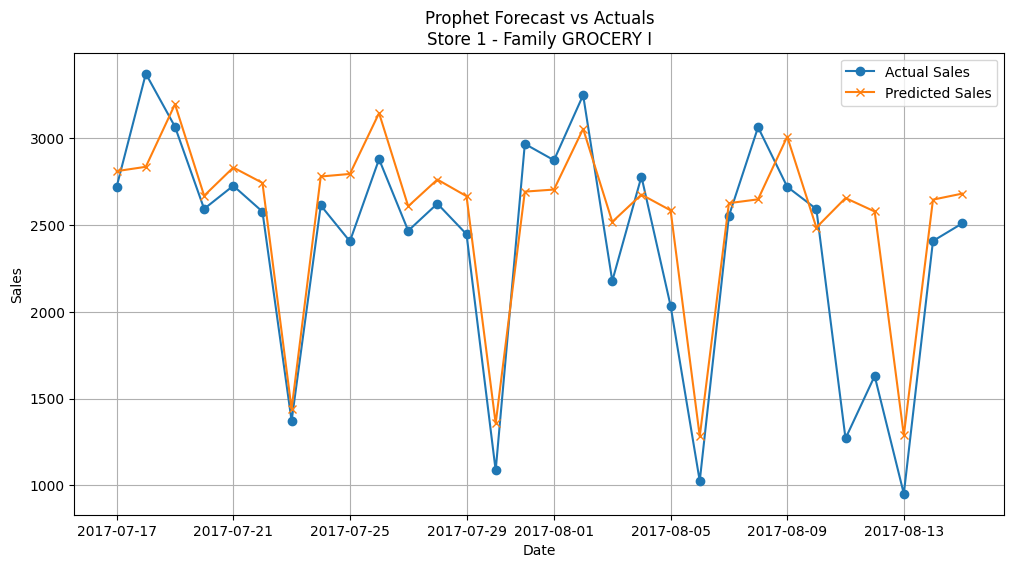

In [9]:
# Test use on GROCERY 1 key
key_store = 1      
key_family = 'GROCERY I' 

model, forecast, df_val_compare = run_prophet_simple(train_df, key_store, key_family, val_days=30)

# Prophet with holidays and regressors

In [10]:
def run_prophet_with_regressors_and_holidays(train_df, holidays_events_df, key_store, key_family, val_days=30):
    """
    Train Prophet with regressors and holidays on train data for one store & family,
    validate on last val_days.

    Parameters:
        train_df : pd.DataFrame - full training data with columns including ['date', 'store_nbr', 'family', 'sales', 'transactions', 'dcoilwtico', 'is_holiday', 'is_weekend']
        holidays_events_df : pd.DataFrame - holidays/events dataframe with ['date', 'locale', 'description']
        key_store : int - store number to filter
        key_family : str - family name to filter
        val_days : int - number of days for validation

    Returns:
        model : trained Prophet model
        forecast : DataFrame with Prophet forecast for train + validation
        df_val_compare : DataFrame comparing actual vs predicted in validation
    """
    # Filter data for the key
    df_key = train_df[(train_df['store_nbr'] == key_store) & (train_df['family'] == key_family)].copy()
    df_key = df_key.sort_values('date')
    
    # Rename for Prophet
    df_key = df_key.rename(columns={'date': 'ds', 'sales': 'y'})
    
    # Split train/validation
    df_train = df_key.iloc[:-val_days]
    df_val = df_key.iloc[-val_days:]
    
    print(f"Training on {len(df_train)} days, validating on {len(df_val)} days")
    
    # Prepare holidays dataframe for Prophet - only National holidays
    holidays = holidays_events_df[holidays_events_df['locale'] == 'National'][['date', 'description']].drop_duplicates()
    holidays = holidays.rename(columns={'date': 'ds', 'description': 'holiday'})
    
    # Initialize Prophet model with holidays
    model = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    
    # Define regressors to add
    regressors = ['transactions', 'dcoilwtico', 'is_holiday', 'is_weekend']
    
    # Add regressors to Prophet
    for reg in regressors:
        if reg not in df_train.columns:
            raise ValueError(f"Regressor '{reg}' not found in training data columns.")
        model.add_regressor(reg)
    
    # Fit model on train data including regressors
    model.fit(df_train[['ds', 'y'] + regressors])
    
    # Prepare future dataframe for prediction (train + validation)
    future = pd.concat([df_train, df_val])[['ds'] + regressors].reset_index(drop=True)
    
    # Predict
    forecast = model.predict(future)
    
    # Compare validation actuals with predictions
    df_val_forecast = forecast.set_index('ds').loc[df_val['ds']]
    df_val_compare = df_val.copy()
    df_val_compare['yhat'] = df_val_forecast['yhat'].values
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(df_val_compare['y'], df_val_compare['yhat']))
    mae = mean_absolute_error(df_val_compare['y'], df_val_compare['yhat'])
    print(f"Validation RMSE: {rmse:.2f}")
    print(f"Validation MAE: {mae:.2f}")
    
    # Plot actual vs predicted for validation
    plt.figure(figsize=(12,6))
    plt.plot(df_val_compare['ds'], df_val_compare['y'], label='Actual Sales', marker='o')
    plt.plot(df_val_compare['ds'], df_val_compare['yhat'], label='Predicted Sales', marker='x')
    plt.title(f'Prophet with Regressors & Holidays\nStore {key_store} - Family {key_family}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model, forecast, df_val_compare

16:31:27 - cmdstanpy - INFO - Chain [1] start processing


Training on 1684 days, validating on 30 days


16:31:27 - cmdstanpy - INFO - Chain [1] done processing


Validation RMSE: 318.05
Validation MAE: 261.31


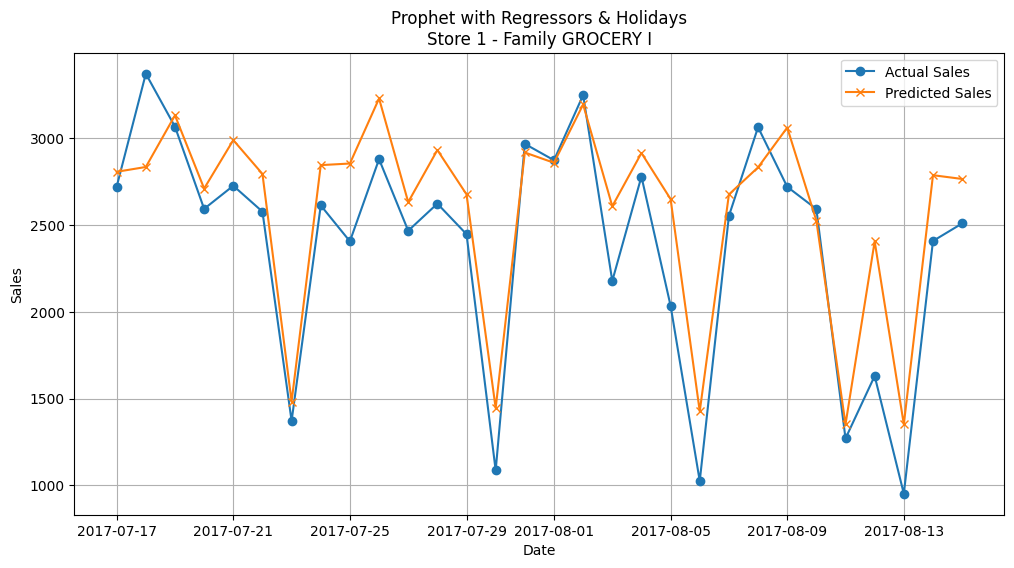

In [11]:
# Test use on GROCERY 1 key, with holidays and regressors
key_store = 1
key_family = 'GROCERY I'
val_days = 30

model, forecast, df_val_compare = run_prophet_with_regressors_and_holidays(
    train_df=train_df,
    holidays_events_df=holidays_events_df,
    key_store=key_store,
    key_family=key_family,
    val_days=val_days
)


# Test use on seperate key

16:31:30 - cmdstanpy - INFO - Chain [1] start processing
16:31:30 - cmdstanpy - INFO - Chain [1] done processing


Training on 1684 days, validating on 30 days
Validation RMSE: 614.16
Validation MAE: 470.38


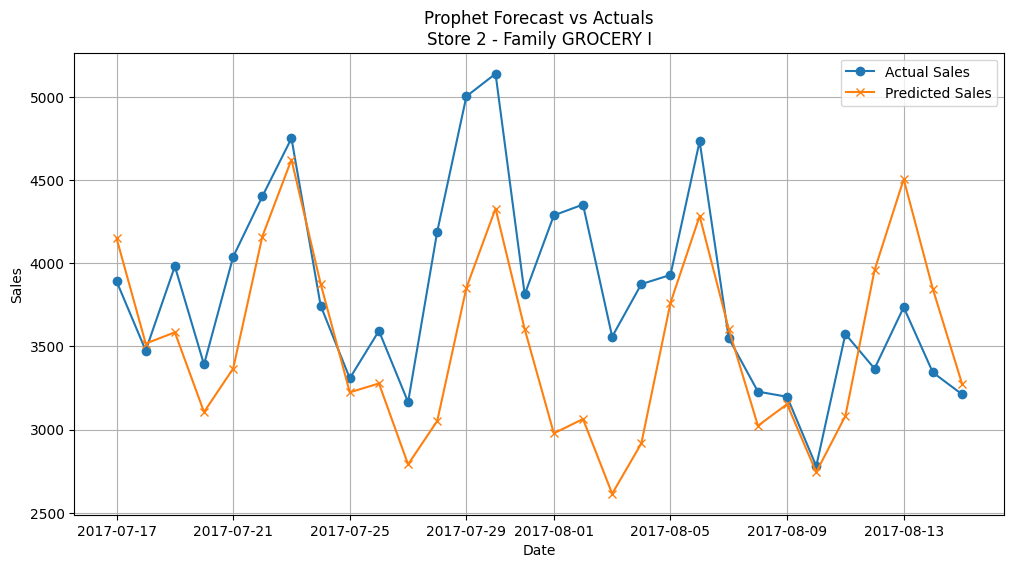

Training on 1684 days, validating on 30 days


16:31:31 - cmdstanpy - INFO - Chain [1] start processing
16:31:31 - cmdstanpy - INFO - Chain [1] done processing


Validation RMSE: 511.50
Validation MAE: 412.33


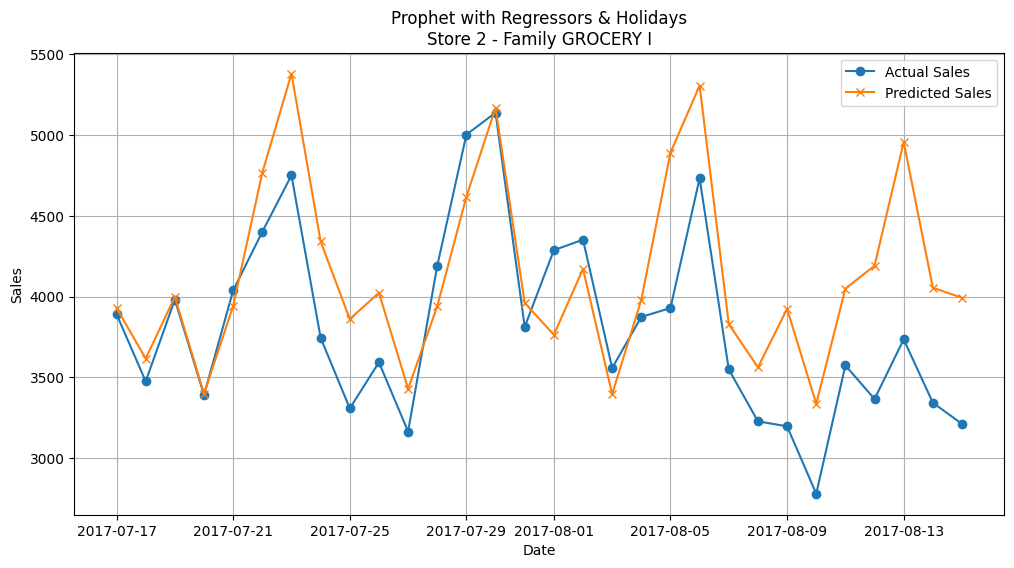

In [12]:
# Test use on GROCERY 1, key 2
key_store = 2      
key_family = 'GROCERY I' 

model, forecast, df_val_compare = run_prophet_simple(train_df, key_store, key_family, val_days=30)


key_store = 2
key_family = 'GROCERY I'
val_days = 30

model, forecast, df_val_compare = run_prophet_with_regressors_and_holidays(
    train_df=train_df,
    holidays_events_df=holidays_events_df,
    key_store=key_store,
    key_family=key_family,
    val_days=val_days
)


# Model Performance

We trained and evaluated two versions of the Prophet model on store sales data:

- **Baseline model:** Using historical sales data alone (no holidays or external regressors).  
- **Enhanced model:** Including holidays and additional regressors such as oil prices, transactions, and weekend indicators.

---

### Performance Metrics (Store 1, Family: GROCERY I, Validation period: 30 days)

| Model                      | Validation RMSE | Validation MAE |
|----------------------------|-----------------|----------------|
| Without holidays/regressors | 395.42          | 286.93         |
| With holidays/regressors    | 318.05          | 261.31         |

**Improvement with additional features:**  
- RMSE reduced by approximately **20%**  
- MAE reduced by approximately **9%**

---

### Performance Metrics (Store 2, Family: GROCERY I)

| Model                      | Validation RMSE | Validation MAE |
|----------------------------|-----------------|----------------|
| Without holidays/regressors | 614.16          | 470.38         |
| With holidays/regressors    | 511.50          | 412.33         |

**Improvement with additional features:**  
- RMSE reduced by approximately **16.7%**  
- MAE reduced by approximately **12.3%**

---

This demonstrates that incorporating holiday information and relevant external regressors significantly enhances the model's ability to capture real-world sales patterns.


## Next Steps

1. **Build a Prophet Modeling Pipeline Script**
   - Create a modularised `.py` file for batch processing multiple keys.
   - Include feature filtering to use only relevant regressors and holidays.
   - Enable parallel model runs to speed up experimentation.

2. **Evaluate Forecast Performance at Key Level**
   - Review RMSE and MAE by store-family pairs.
   - Identify and investigate outlier keys with poor performance.
   - Explore alternative modeling approaches for underperforming segments (e.g., different seasonality settings or XGBoost).

3. **Generate Final Predictions on Test Set**
   - Run the selected Prophet model on all keys.
   - Merge and format test predictions according to submission requirements.
   - Produce summary plots, including:
     - Overall sales trends.
     - Forecast vs. actuals on the validation set.
     - Error distribution by key.

---

This marks the completion of the **Initial Prophet modeling** stage. The next steps will focus on scaling the pipeline, deeper evaluation, and producing final outputs.
